# Plots For 11/27/2018 Presentation
---
Plots in the slide deck presented to Nathan on 11/27/2018 have been generated through this notebook.

In [1]:
import sys
sys.path.append("../../")

In [2]:
import analyze
from plot.analyze_pg import AnalyzePG
from westernintnet.westernintnet import win_data
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()

c:\program files\python\python36\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Loading sub
Loading bus2sub
Loading bus
Loading genbus
Loading branches
Loading resources
Loading net_generation
Done loading


Download data from server. This needs to be done once per scenario. Since this procedure is lengthy, the data are saved locally as a pickle file.

sftp = analyze.setup_server_connection("U:\\.ssh\\id_rsa")  
scenario_list = analyze.get_scenario_file_from_server(sftp)
scenario = 'western_scenario_Update01'
"""  
scenario = 'california2030Test01'  
scenario = 'california2020Test01'  
scenario = 'western_scenario_Update01'  
"""  
print('scenario: %s' % scenario)  
PG = analyze.get_PG(sftp, scenario_list, scenario)  
PG.to_pickle('U:\\PGData\\California_Nov2018\\PG.pkl')

In [3]:
def get_plant_id(zone, resource):
    plant_id = []
    if zone == 'Western':
        try:
            plant_id = win_data.genbus.groupby('type').get_group(resource).index.values.tolist()
        except KeyError:
            pass
    elif zone == 'California':
        CA = ['Bay Area', 'Central California', 'Northern California',
                'Southeast California', 'Southwest California']
        for load_zone in CA:
            try:
                plant_id += win_data.genbus.groupby(['ZoneName', 'type']).get_group(
                    (load_zone, resource)).index.values.tolist()
            except KeyError:
                pass
    else:
        try:
            plant_id = win_data.genbus.groupby(['ZoneName', 'type']).get_group(
                (zone, resource)).index.values.tolist()
        except KeyError:
            pass
    
    return plant_id

## Base Case
Multiperiod  
Solar power: SAM  
demand v3  
No multiplier for any of the generator in the grid

In [4]:
win_data.read_demand_data('v3')
win_data.read_solar_data('sam')
win_data.read_wind_data()

Load demand data
Load solar data
Load wind data


In [5]:
multiplier = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)

In [6]:
PG = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG.pkl')

### 1. Chart

Set UTC for all zones


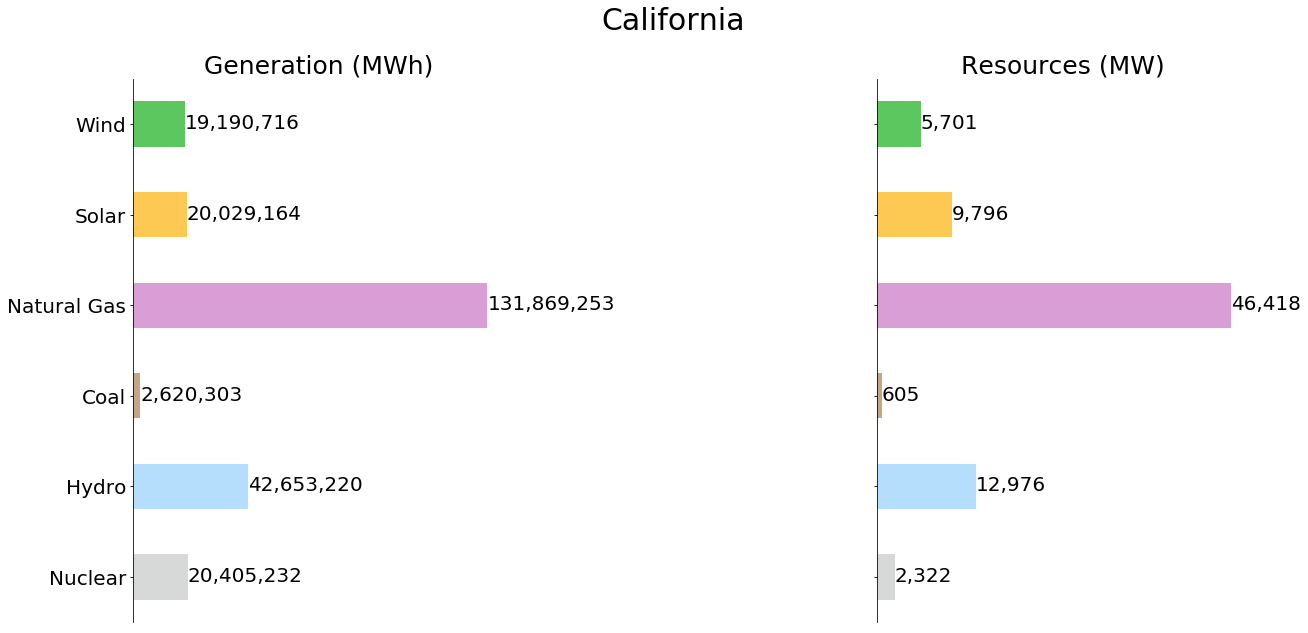

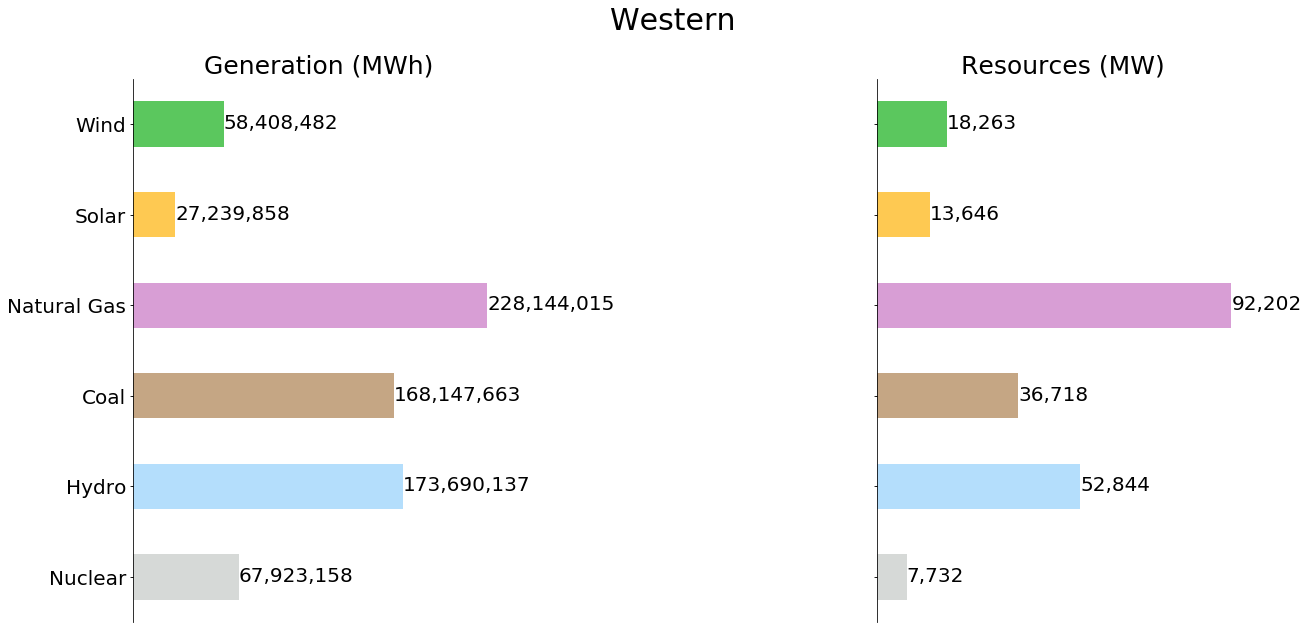

Total Generation in Western Interconnection: 723553316 MWh
Total Capacity in Western Interconnection: 221409 MW


In [7]:
chart = AnalyzePG((PG, win_data, multiplier),
    ('2016-01-01-00', '2016-12-31-23', 'utc', 'H'),
    ['California', 'Western'],
    ['nuclear', 'hydro', 'coal', 'ng', 'solar', 'wind'],
    'chart', normalize=False)
chart.get_plot(save=False)
data_chart = chart.get_data()
print("Total Generation in Western Interconnection: %d MWh" % round(data_chart['Western']['Generation'].sum().sum()))
print("Total Capacity in Western Interconnection: %d MW" % round(data_chart['Western']['Capacity'].sum()))

### 2. Stack

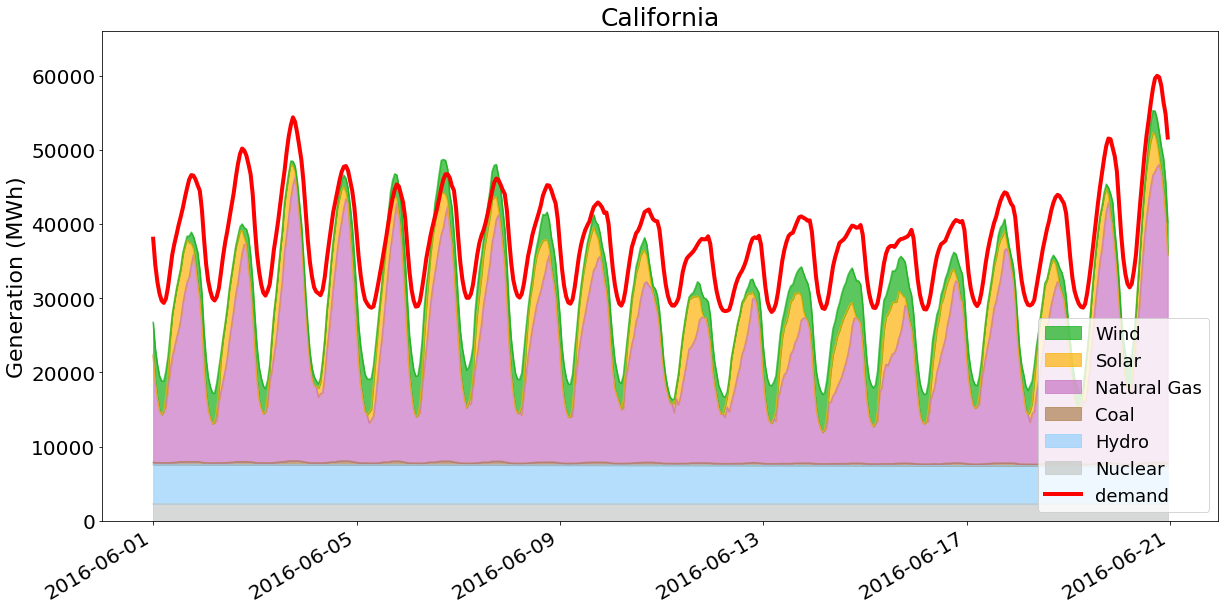

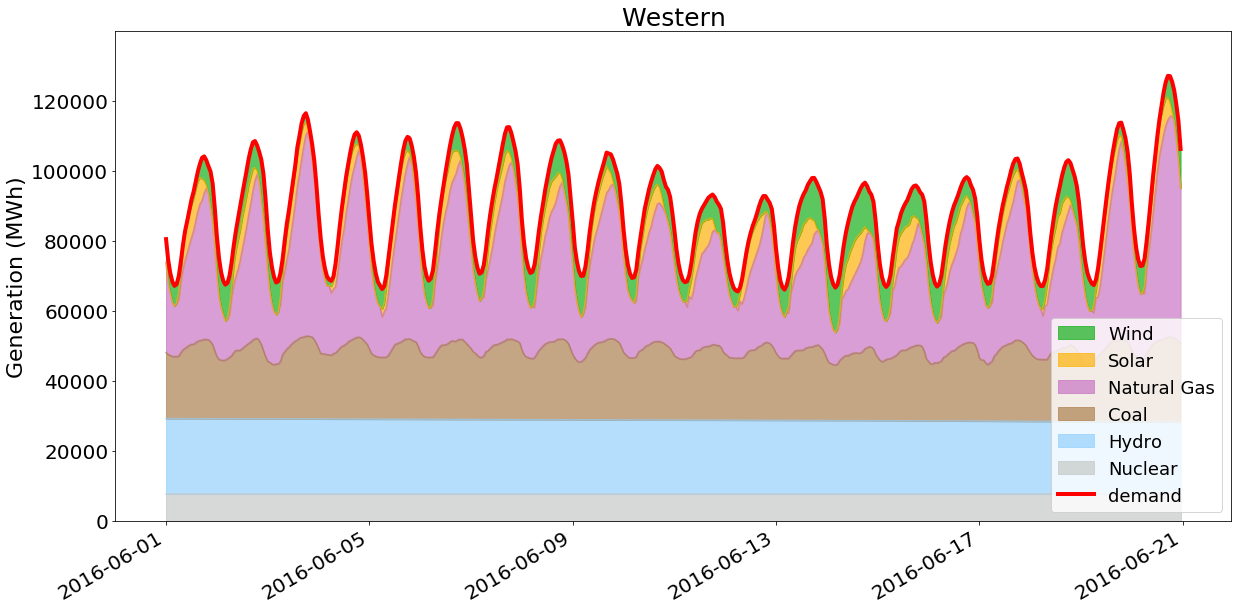

Generation in the Western interconnection in MWh:
32686719.982556183


In [8]:
stack = AnalyzePG((PG, win_data, multiplier),
    ('2016-06-01-00', '2016-06-20-23', 'local', 'H'),
    ['California', 'Western'],
    ['nuclear', 'coal', 'ng', 'hydro', 'wind', 'solar'],
    'stacked', normalize=False)
stack.get_plot(save=False)
data_stack = stack.get_data()
print("Generation in the Western interconnection in MWh:")
print(data_stack['California'].sum().sum())

### 3. Curtailment

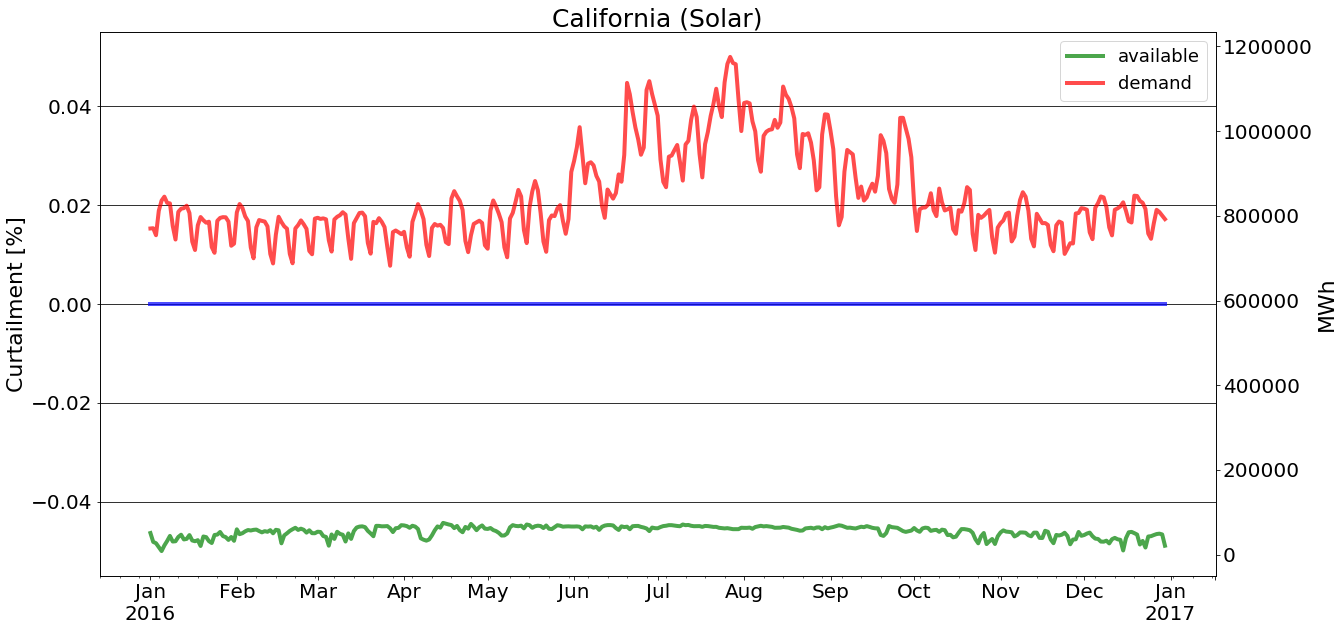

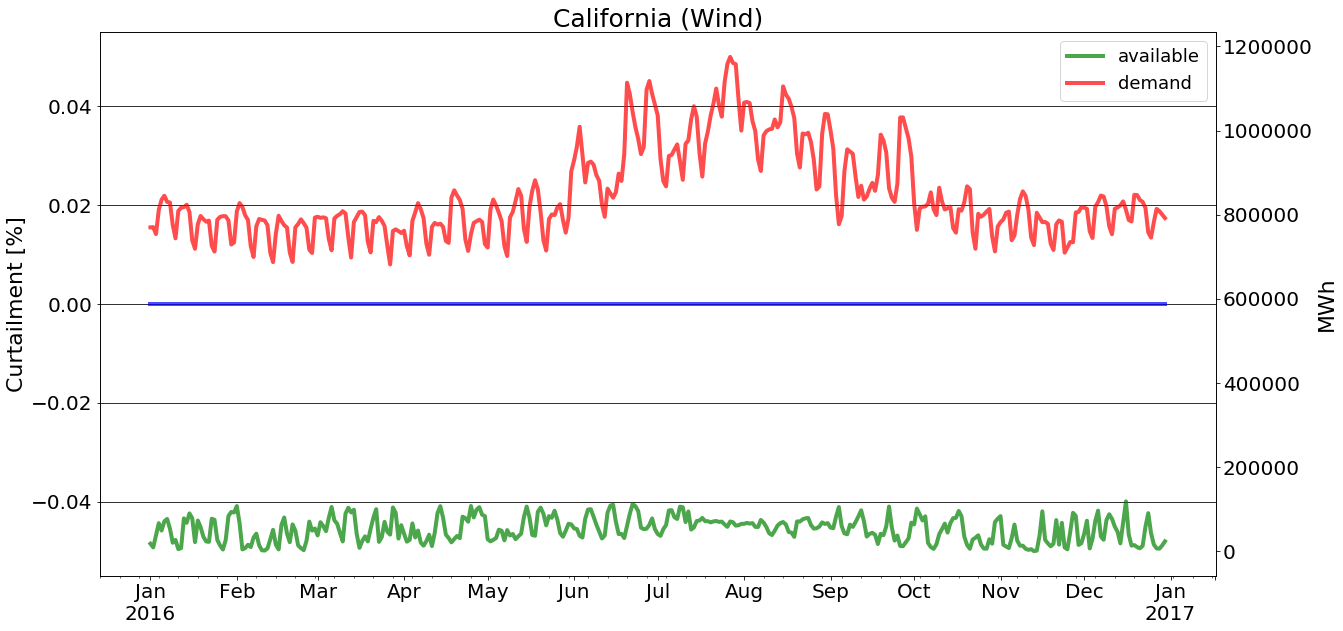

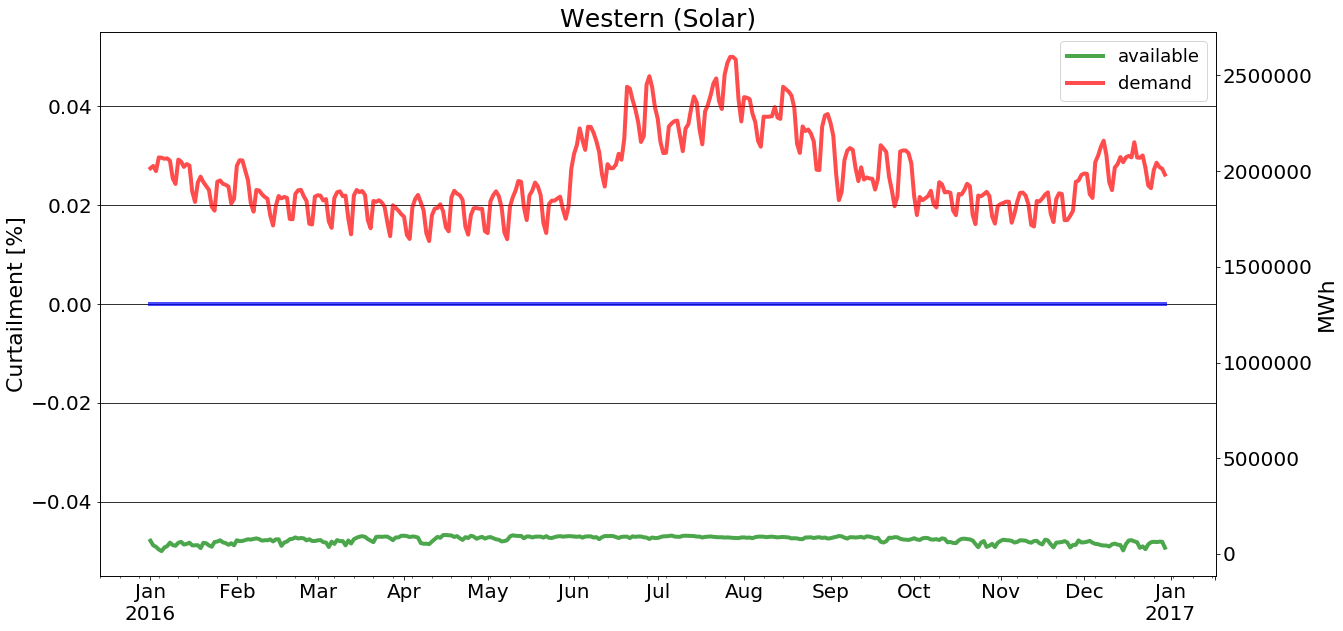

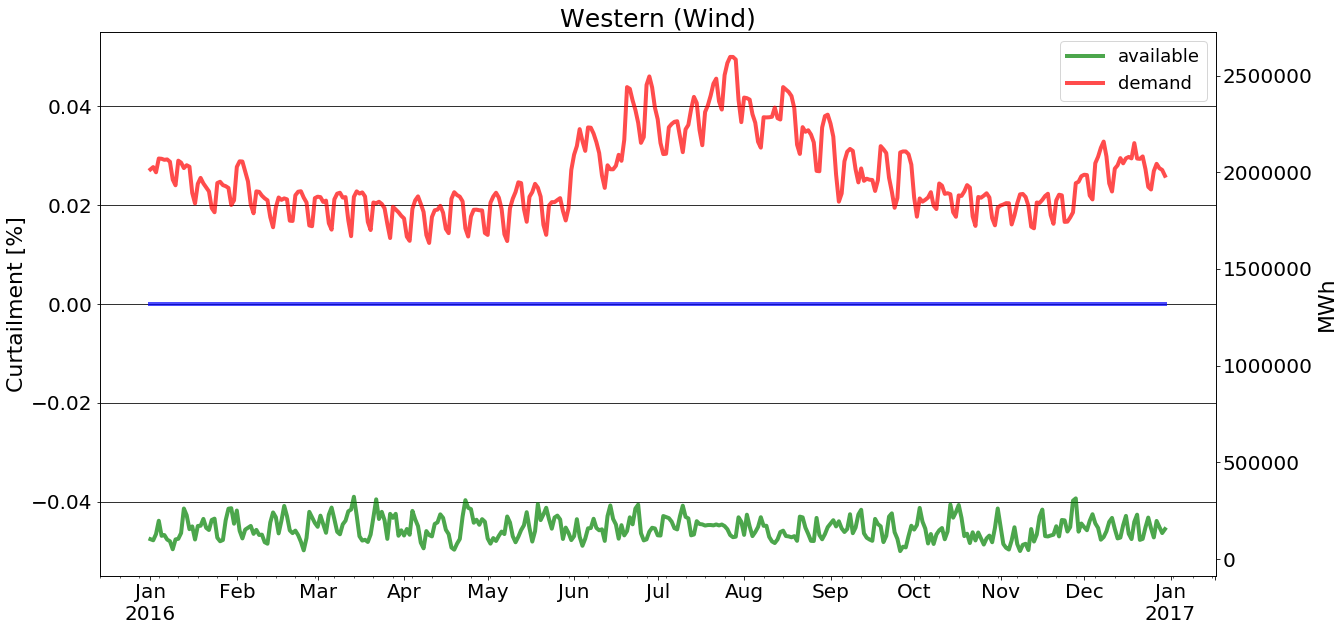

Maximum curtailment for solar generators in the Western Interconnection: 0 %


In [9]:
curtailment = AnalyzePG((PG, win_data, multiplier),
    ('2016-01-01-00', '2016-12-31-23', 'local', 'D'),
    ['California', 'Western'],
    ['solar', 'wind'],
    'curtailment', normalize=False)
curtailment.get_plot(save=False)
data_curtailment = curtailment.get_data()
print("Maximum curtailment for solar generators in the Western Interconnection: %d %%" % 
      round(data_curtailment['Western']['solar'].ratio.max()))

## California 2020
Multiperiod  
Solar power: SAM  
demand v3  
multiplier: 1.52 for solar power output in CA and 1.48 for wind power output in CA.

In [10]:
win_data.read_demand_data('cal2020')
win_data.read_solar_data('sam')
win_data.read_wind_data()

Load demand data
Load solar data
Load wind data


In [11]:
factor_2020 = [1.52, 1.48]
multiplier_2020 = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)
for i, resource in enumerate(['solar', 'wind']):
    plant_id = get_plant_id('California', resource)
    multiplier_2020.loc[plant_id] = factor_2020[i]

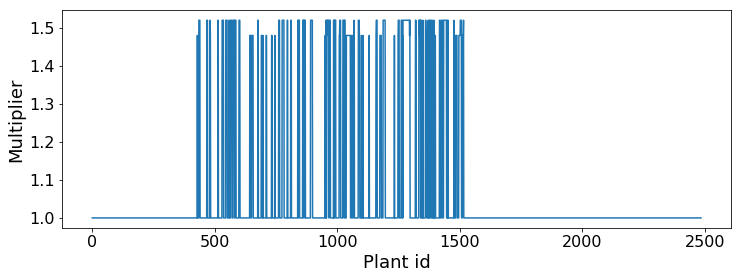

In [12]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12,4))

ax = fig.gca()
multiplier_2020.plot(ax=ax, legend=False)
ax.set_xlabel('Plant id', fontsize=18)
ax.set_ylabel('Multiplier', fontsize=18)
ax.tick_params(labelsize=16)
plt.show()

In [13]:
PG_2020 = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2020.pkl')

### 1. Stack

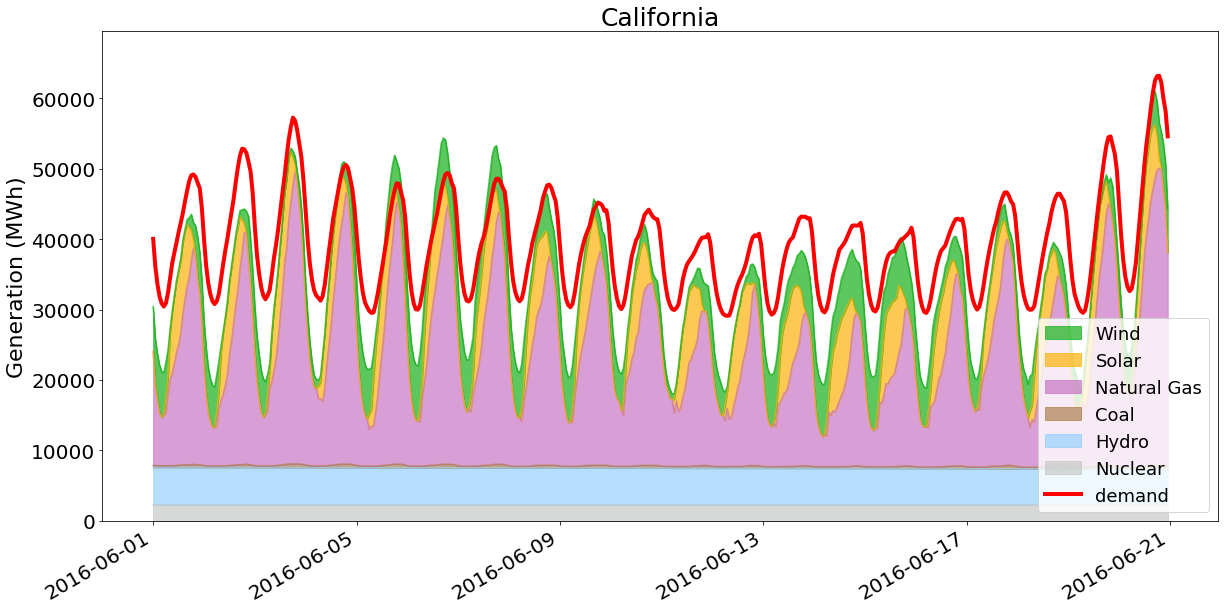

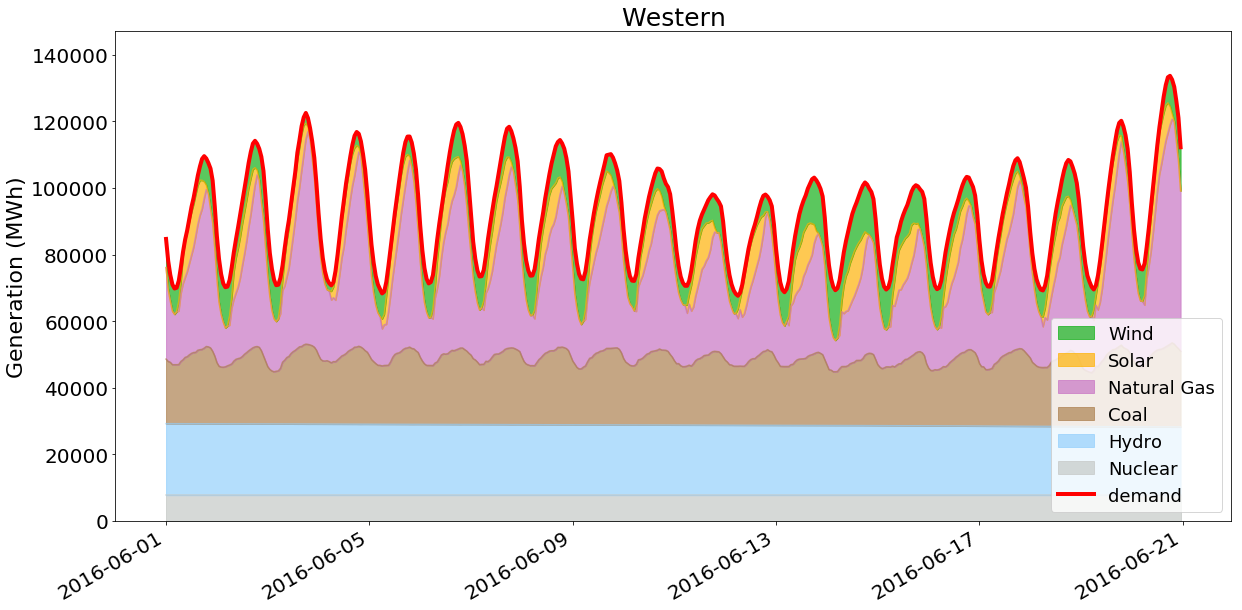

Generation in the Western interconnection in MWh:
35015151.32356825


In [14]:
stack_2020 = AnalyzePG((PG_2020, win_data, multiplier_2020),
    ('2016-06-01-00', '2016-06-20-23', 'local', 'H'),
    ['California', 'Western'],
    ['nuclear', 'coal', 'ng', 'hydro', 'wind', 'solar'],
    'stacked', normalize=False)
stack_2020.get_plot(save=False)
data_stack_2020 = stack_2020.get_data()
print("Generation in the Western interconnection in MWh:")
print(data_stack_2020['California'].sum().sum())

### 2. Curtailment

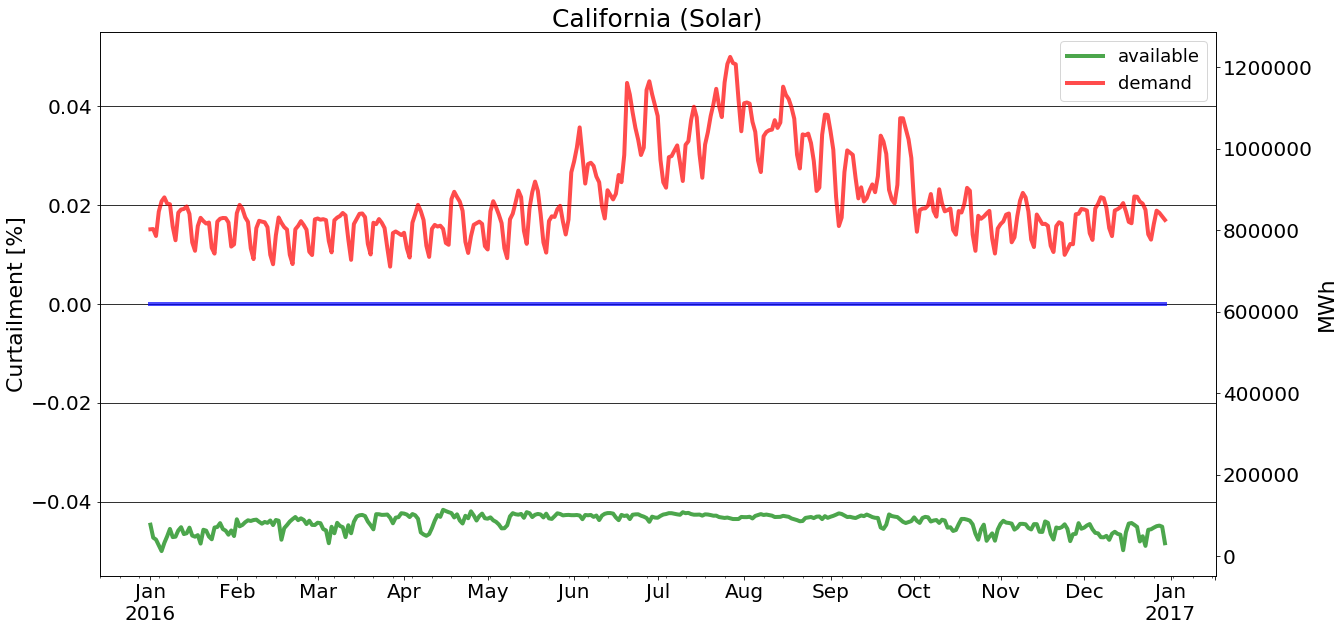

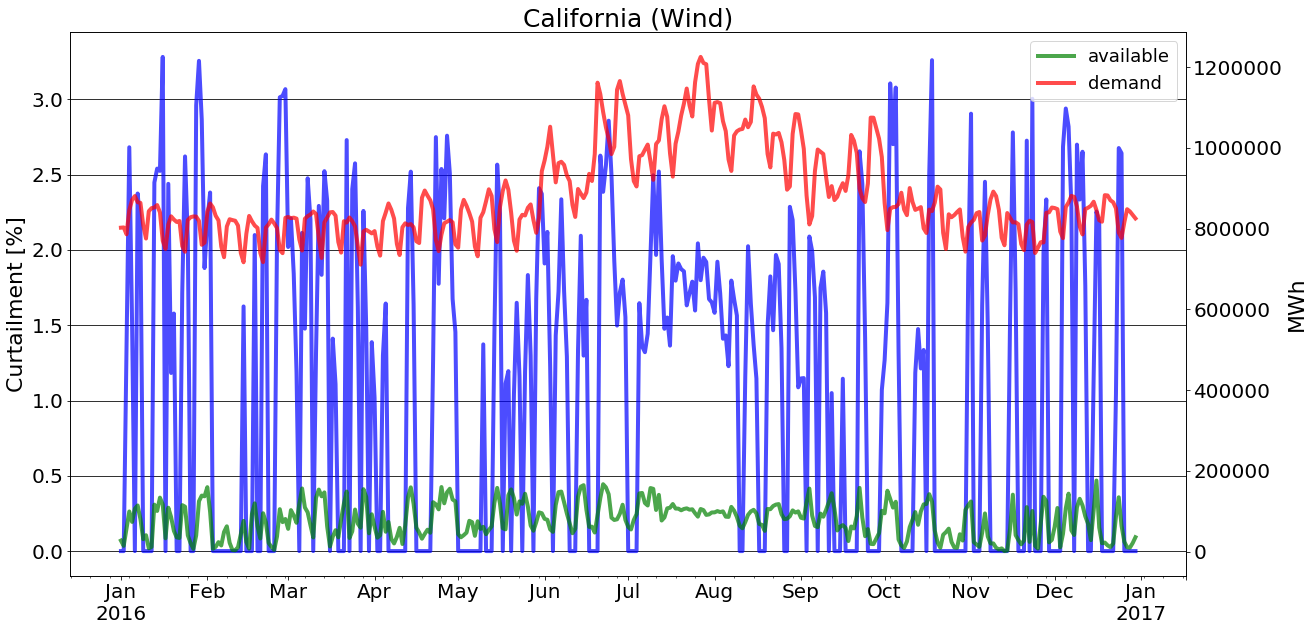

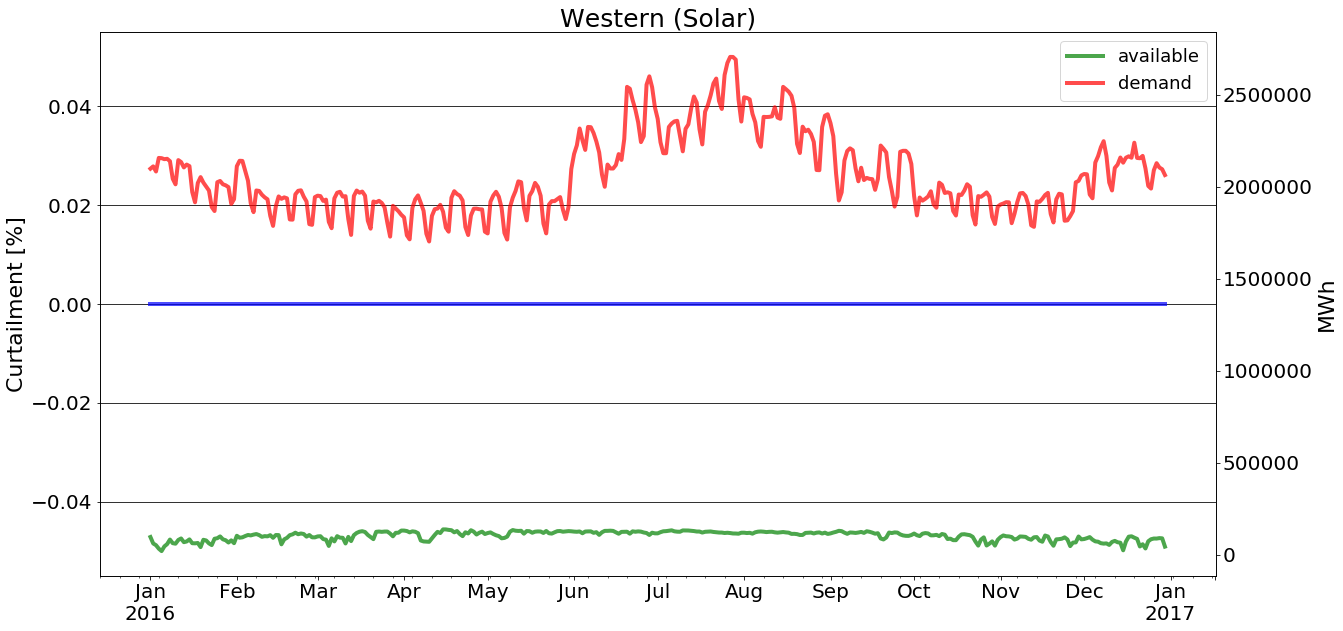

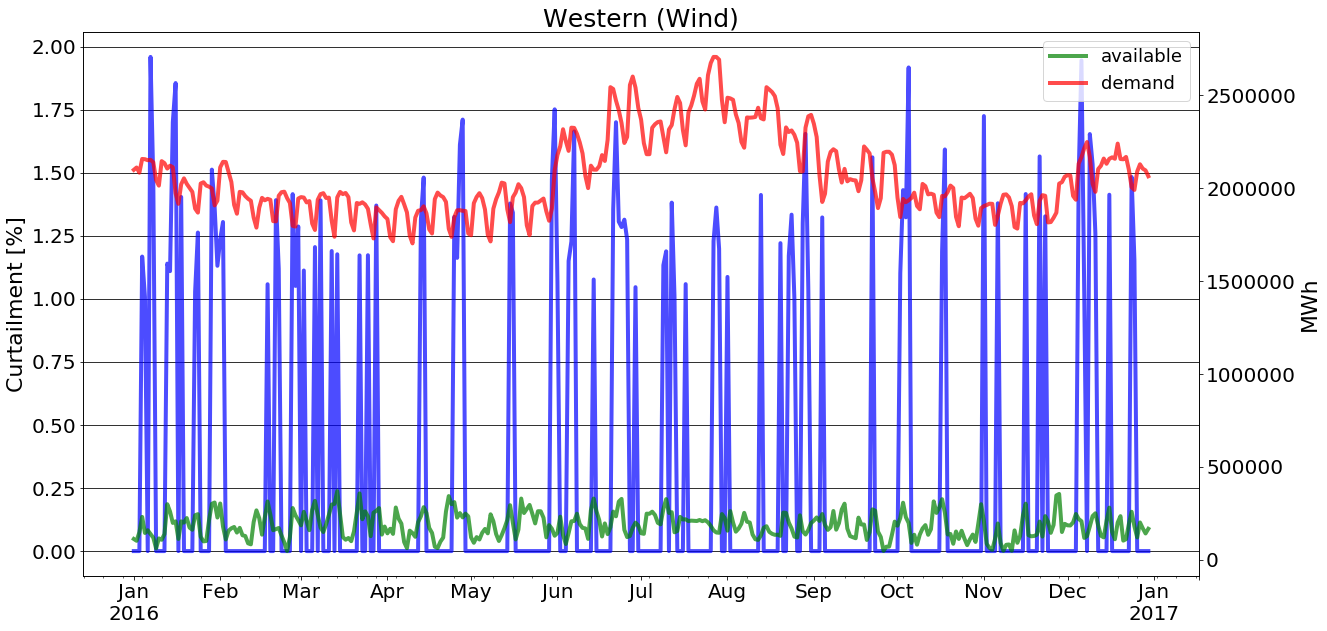

In [15]:
curtailment_2020 = AnalyzePG((PG_2020, win_data, multiplier_2020),
                             ('2016-01-01-00', '2016-12-31-23', 'local', 'D'),
                             ['California', 'Western'],
                             ['solar', 'wind'],
                             'curtailment', normalize=False)
curtailment_2020.get_plot(save=False)
data_curtailment_2020 = curtailment_2020.get_data()

In [16]:
for zone in ['California', 'Western']:
    for resource in ['solar', 'wind']:
        available_2020 = data_curtailment_2020[zone][resource].available.sum() 
        generated_2020 = data_curtailment_2020[zone][resource].generated.sum()
        curtailment_2020 = 100 * (available_2020 - generated_2020) / available_2020
        print("Curtailment %s/%s: %.1f %%" % (zone, resource, curtailment_2020))

Curtailment California/solar: 0.0 %
Curtailment California/wind: 1.6 %
Curtailment Western/solar: 0.0 %
Curtailment Western/wind: 0.7 %


## California 2030
Multiperiod  
Solar power: SAM  
demand v3  
multiplier: 2.3 for solar and wind power output in CA.

In [17]:
win_data.read_demand_data('cal2030')
win_data.read_solar_data('sam')
win_data.read_wind_data()

Load demand data
Load solar data
Load wind data


In [18]:
factor_2030 = [2.3, 2.3]
multiplier_2030 = pd.DataFrame({'multiplier': [1]*len(win_data.genbus)}, index=win_data.genbus.index.values)
for i, resource in enumerate(['solar', 'wind']):
    plant_id = get_plant_id('Western', resource)
    multiplier_2030.loc[plant_id] = factor_2030[i]

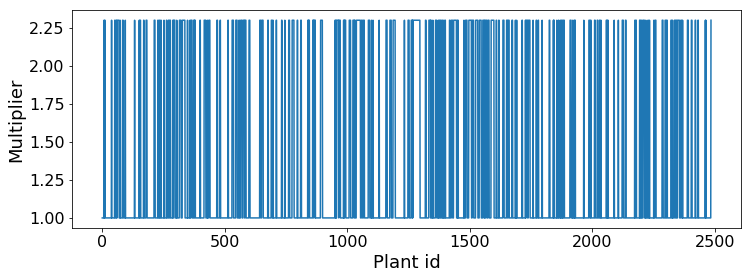

In [19]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(12,4))

ax = fig.gca()
multiplier_2030.plot(ax=ax, legend=False)
ax.set_xlabel('Plant id', fontsize=18)
ax.set_ylabel('Multiplier', fontsize=18)
ax.tick_params(labelsize=16)
plt.show()

In [20]:
PG_2030 = pd.read_pickle('U:\\PGData\\California_Nov2018\\PG_CA2030.pkl')

### 1. Stack

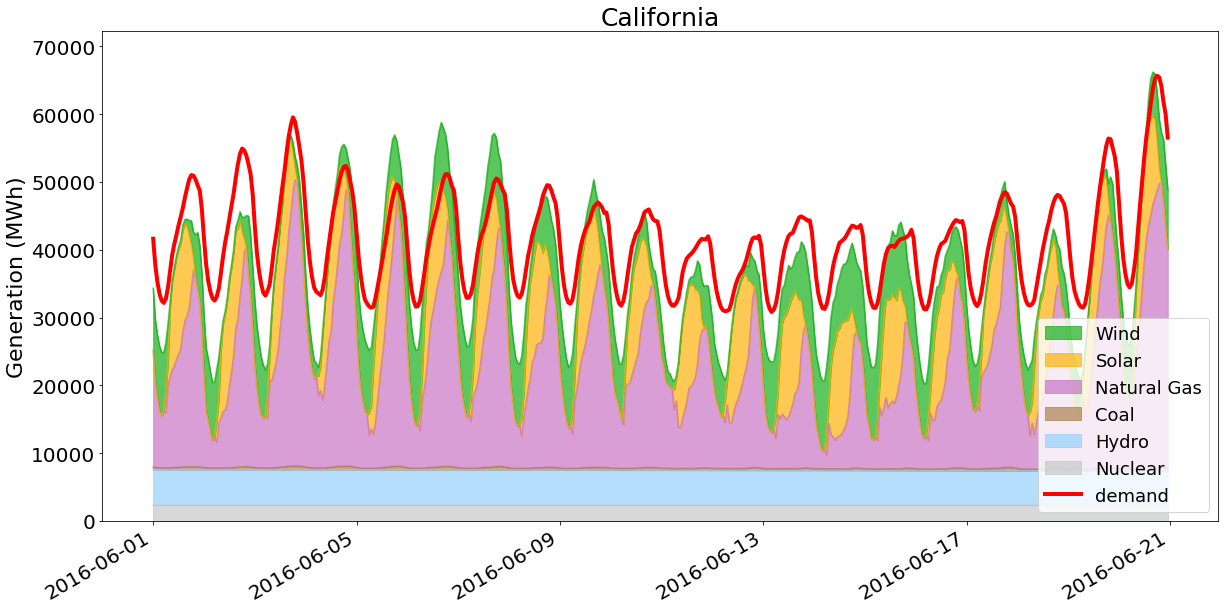

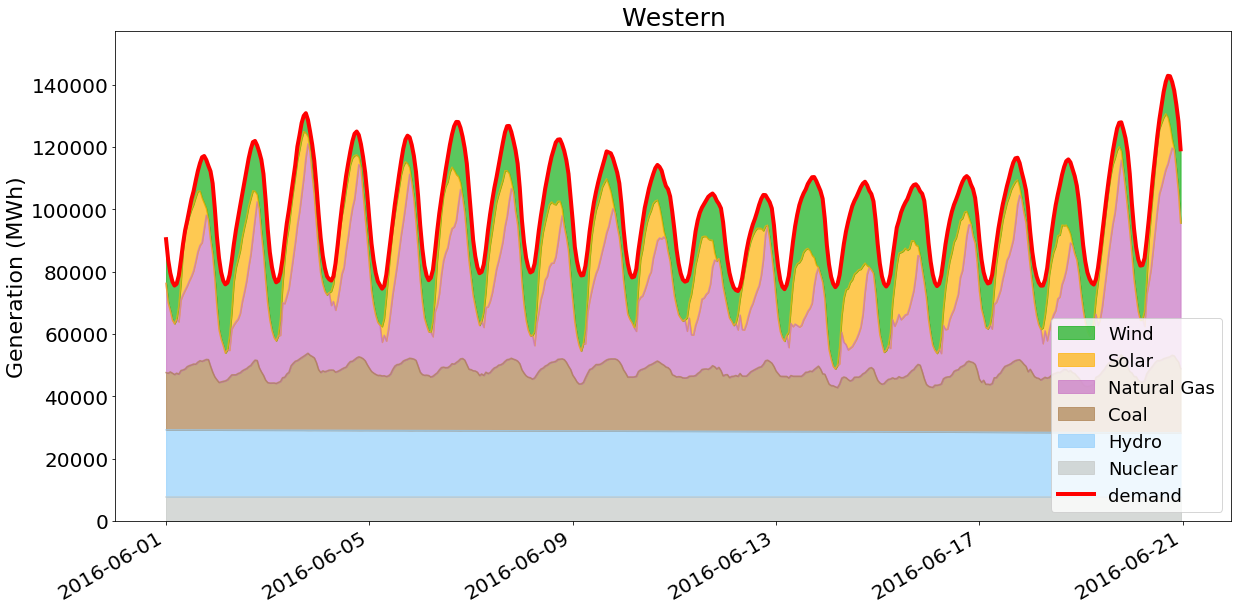

Generation in the Western interconnection in MWh:
37461423.93497646


In [21]:
stack_2030 = AnalyzePG((PG_2030, win_data, multiplier_2030),
    ('2016-06-01-00', '2016-06-20-23', 'local', 'H'),
    ['California', 'Western'],
    ['nuclear', 'coal', 'ng', 'hydro', 'wind', 'solar'],
    'stacked', normalize=False)
stack_2030.get_plot(save=False)
data_stack_2030 = stack_2030.get_data()
print("Generation in the Western interconnection in MWh:")
print(data_stack_2030['California'].sum().sum())

### 2. Curtailment

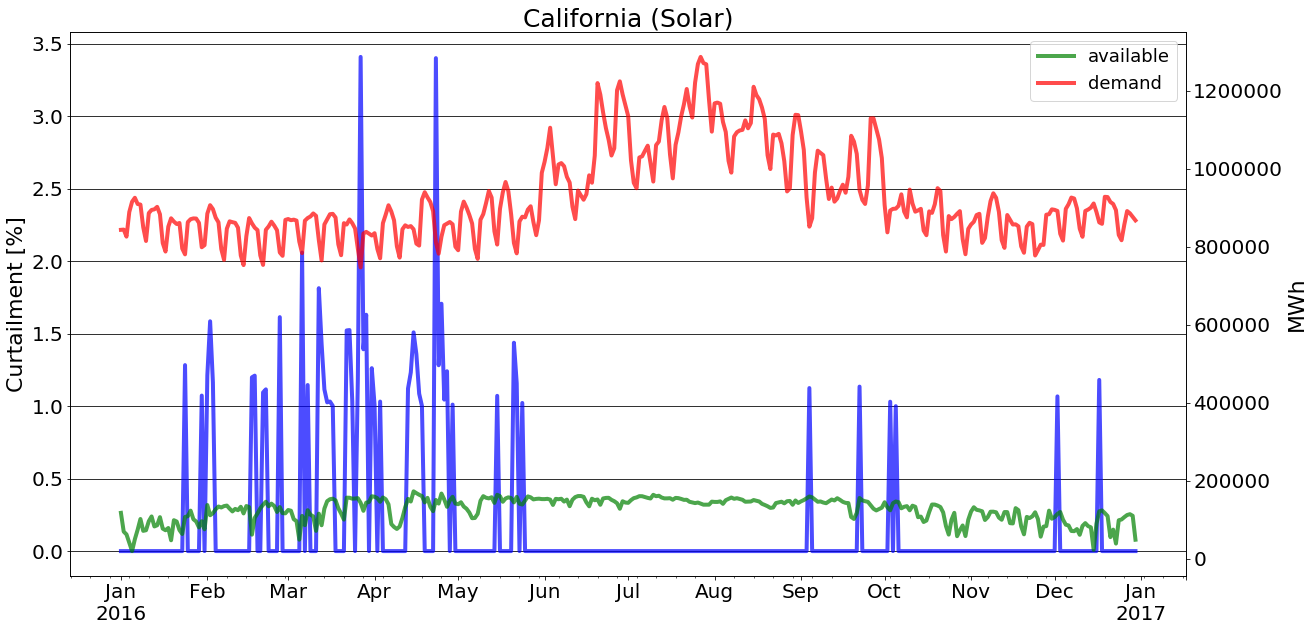

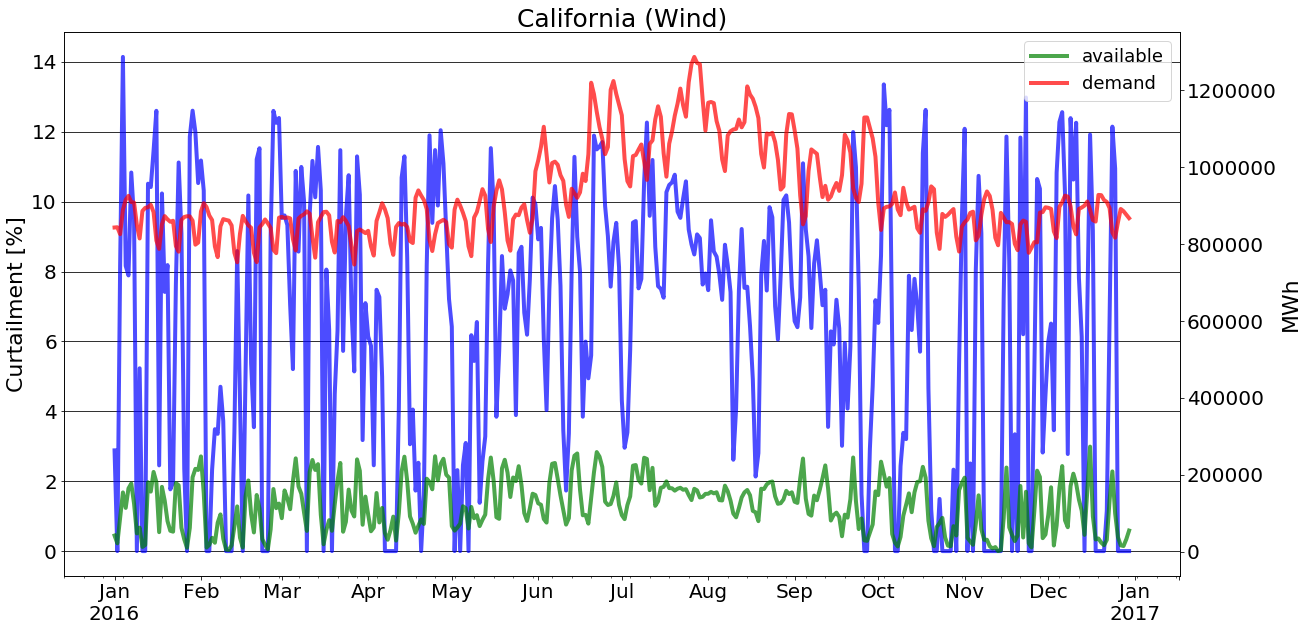

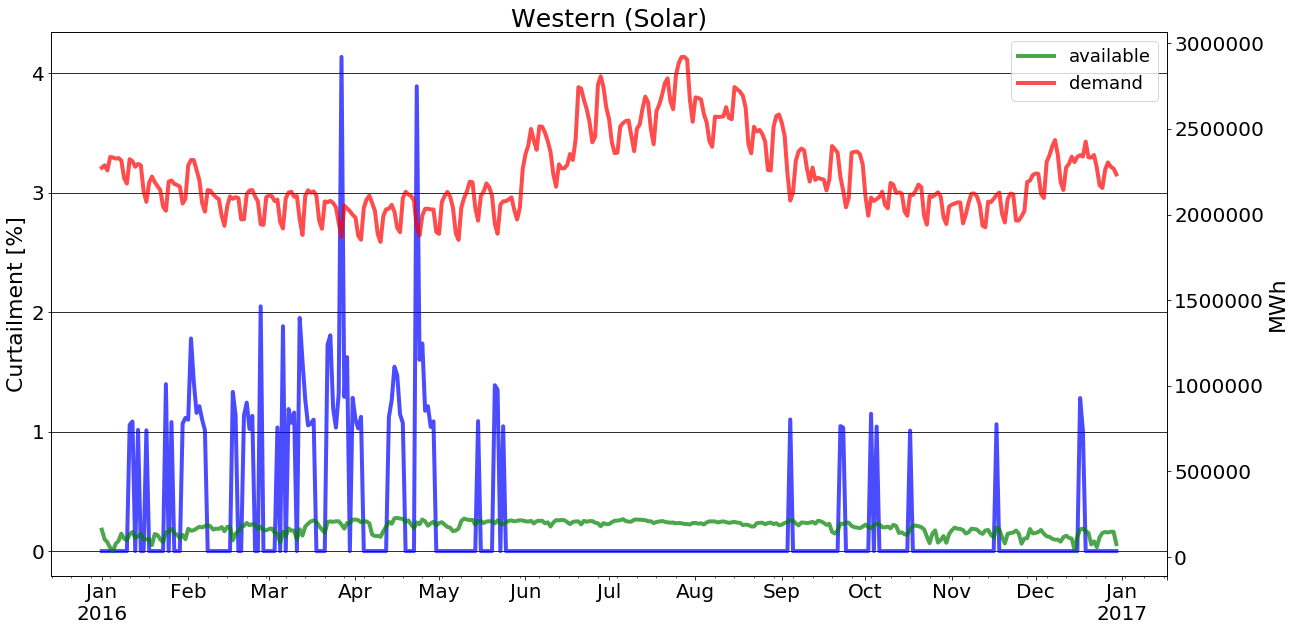

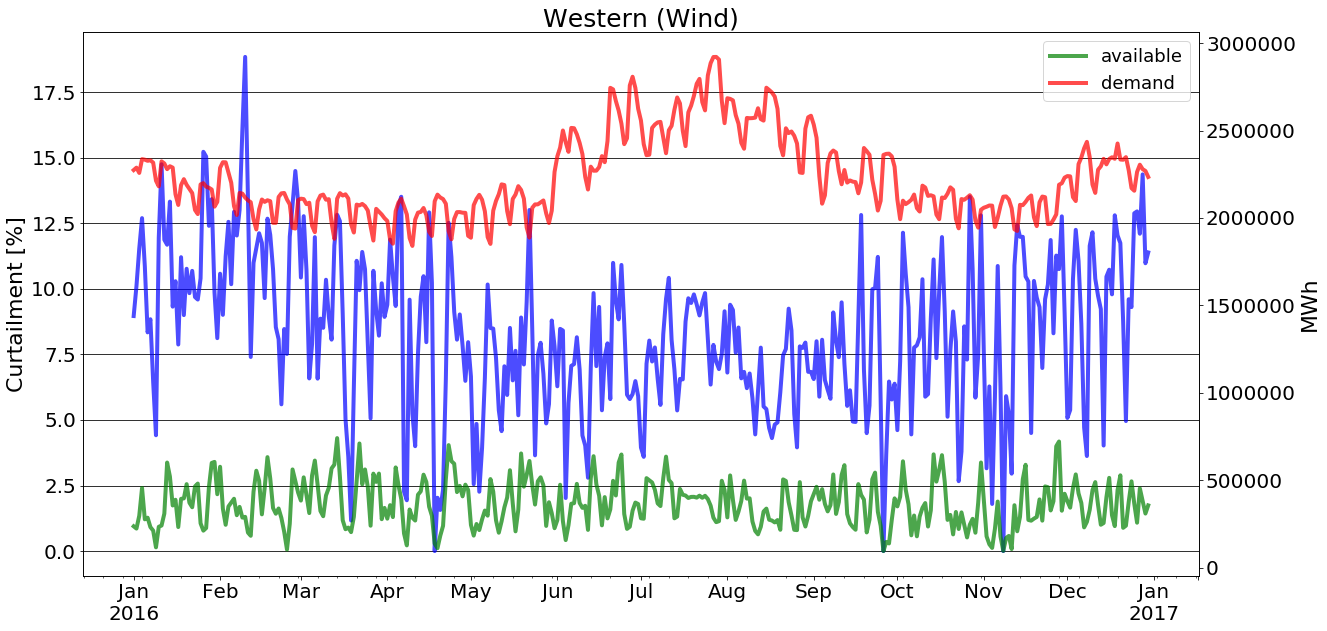

In [22]:
curtailment_2030 = AnalyzePG((PG_2030, win_data, multiplier_2030),
                             ('2016-01-01-00', '2016-12-31-23', 'local', 'D'),
                             ['California', 'Western'],
                             ['solar', 'wind'],
                             'curtailment', normalize=False)
curtailment_2030.get_plot(save=False)
data_curtailment_2030 = curtailment_2030.get_data()

In [23]:
for zone in ['California', 'Western']:
    for resource in ['solar', 'wind']:
        available_2030 = data_curtailment_2030[zone][resource].available.sum() 
        generated_2030 = data_curtailment_2030[zone][resource].generated.sum()
        curtailment_2030 = 100 * (available_2030 - generated_2030) / available_2030
        print("Curtailment %s/%s: %.1f %%" % (zone, resource, curtailment_2030))

Curtailment California/solar: 0.7 %
Curtailment California/wind: 8.3 %
Curtailment Western/solar: 0.8 %
Curtailment Western/wind: 8.9 %
